# table detection and structure recognition using Oopen cv

La quantité de données collectées augmente considérablement de jour en jour avec de nombreuses applications, outils et
plateformes en ligne dans l'ère technologique actuelle. Pour gérer et accéder de manière productive à ces énormes données, il est nécessaire de développer de précieux outils d'extraction d'informations. L'un des sous-domaines qui exigent une attention particulière dans le domaine de l'extraction d'informations est la récupération et l'accès aux données à partir de formulaires tabulaires.

Étant donné une image comprenant du texte aléatoire et un tableau, l'objectif est d'extraire des données uniquement à partir du tableau

Nous utiliserons des techniques traditionnelles de vision par ordinateur pour extraire des informations des tables numérisées. Voici notre pipeline:

* Tout d'abord nous détectons les tables dans l'image(les tableaux d'où nous devons extraire les informations), puis nous essaierons de trouver les bordures, les bords et les cellules. Nous utiliserons différents filtres et contours, et nous mettrons en évidence les principales caractéristiques des tableaux.

Nous aurons besoin d'une image d'une table. Nous pouvons capturer cela sur un téléphone ou utiliser n'importe quelle image existante.

La première étape consiste à lire votre fichier à partir du chemin approprié, en utilisant le seuillage pour convertir l'image d'entrée en une image binaire et en l'inversant pour obtenir un fond noir et des lignes et des polices blanches. Ci-dessous l'extrait de code

In [60]:
import cv2
import numpy as np

def adaptive_threshold(imagename, process_background=False, blocksize=15, c=-2):
    """Thresholds an image using OpenCV's adaptiveThreshold.
    Parameters
    ----------
    imagename : string
        Path to image file.
    process_background : bool, optional (default: False)
        Whether or not to process lines that are in background.
    blocksize : int, optional (default: 15)
        Size of a pixel neighborhood that is used to calculate a
        threshold value for the pixel: 3, 5, 7, and so on.
        For more information, refer `OpenCV's adaptiveThreshold <https://docs.opencv.org/2.4/modules/imgproc/doc/miscellaneous_transformations.html#adaptivethreshold>`_.
    c : int, optional (default: -2)
        Constant subtracted from the mean or weighted mean.
        Normally, it is positive but may be zero or negative as well.
        For more information, refer `OpenCV's adaptiveThreshold <https://docs.opencv.org/2.4/modules/imgproc/doc/miscellaneous_transformations.html#adaptivethreshold>`_.
    Returns
    -------
    img : object
        numpy.ndarray representing the original image.
    threshold : object
        numpy.ndarray representing the thresholded image.
    """
    img = cv2.imread(imagename)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    if process_background:
        threshold = cv2.adaptiveThreshold(
            gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, blocksize, c
        )
    else:
        threshold = cv2.adaptiveThreshold(
            np.invert(gray),
            255,
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY,
            blocksize,
            c,
        )
    return img, threshold

In [61]:
imagename = r'C:\DEV\Table_Detection\data\fact230001-1.png'
process_background = False
threshold_blocksize = 15
threshold_constant = -2
image, threshold = adaptive_threshold(
            imagename,
            process_background=process_background,
            blocksize=threshold_blocksize,
            c=threshold_constant,
        )

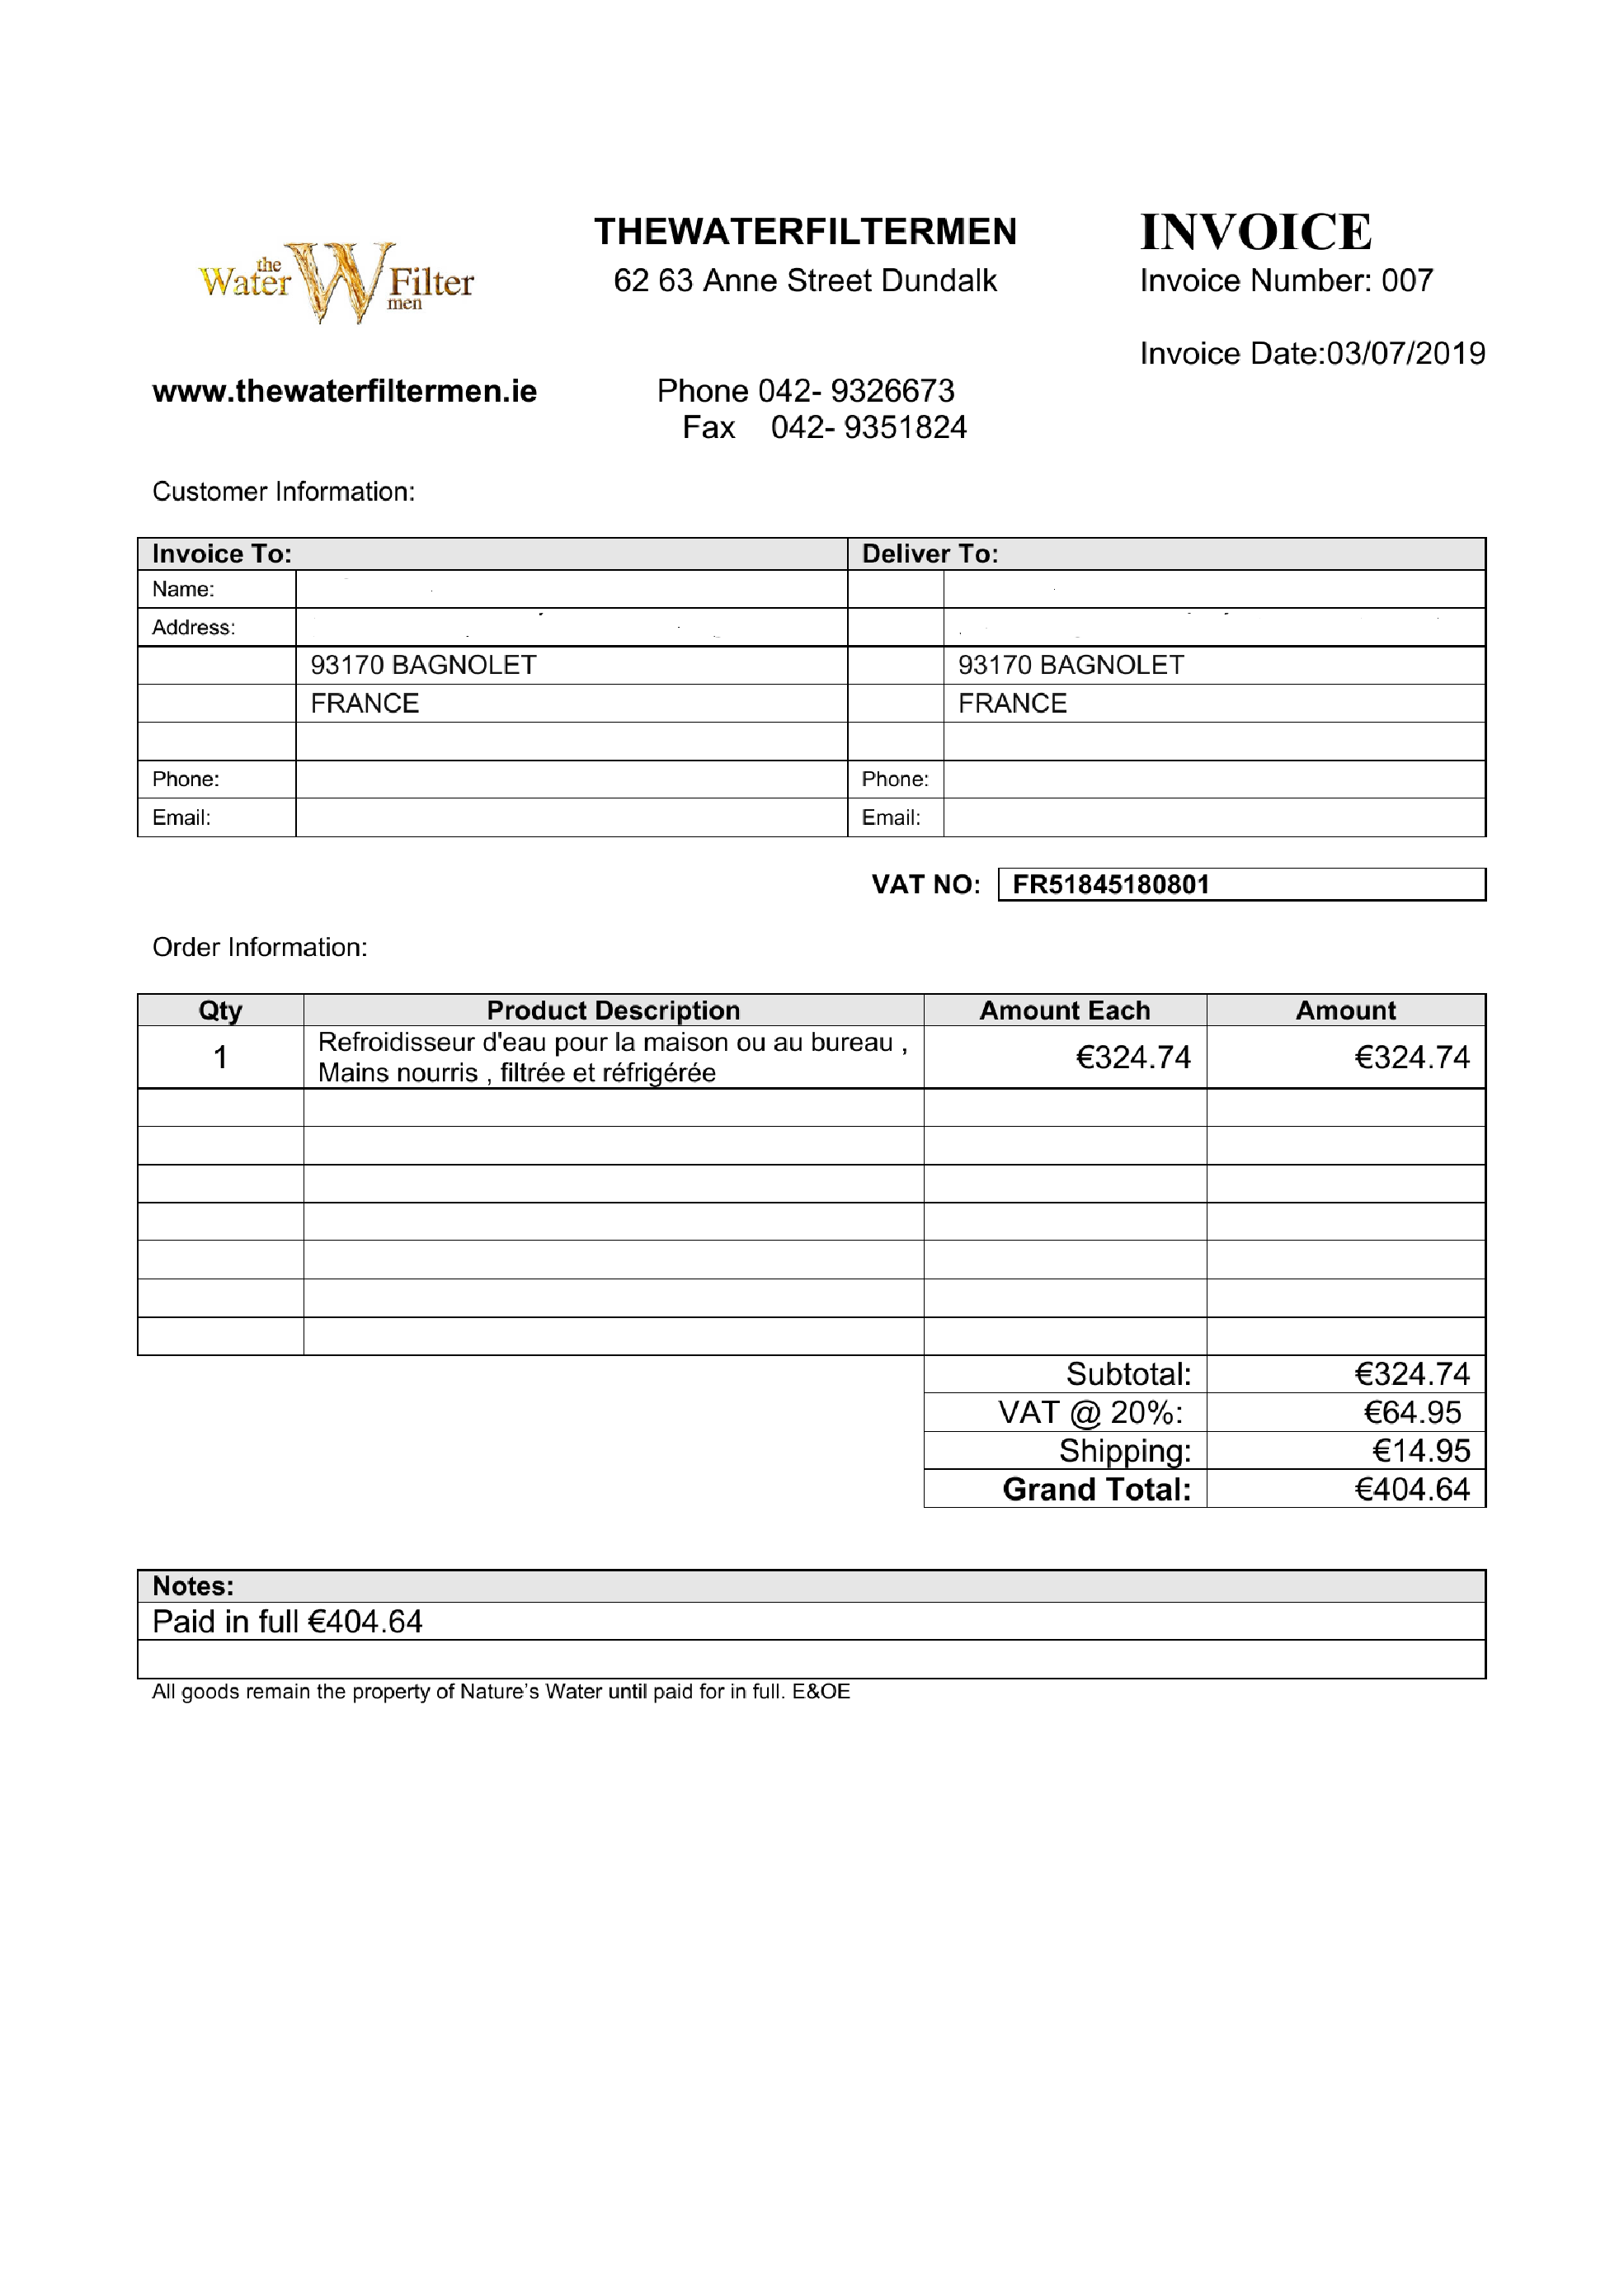

In [62]:
import matplotlib.pyplot as plt
# set size
plt.figure(figsize=(50,50))
plt.axis("off")

plt.imshow(image)
plt.show()

L'étape suivante consiste à définir un noyau pour détecter les boîtes rectangulaires, puis la structure tabulaire. Tout d'abord, nous définissons la longueur du noyau et en suivant les noyaux verticaux et horizontaux pour détecter toutes les lignes verticales et toutes les lignes horizontales.

In [64]:
def find_lines(
    threshold, regions=None, direction="horizontal", line_scale=15, iterations=0
):
    """Finds horizontal and vertical lines by applying morphological
    transformations on an image.
    Parameters
    ----------
    threshold : object
        numpy.ndarray representing the thresholded image.
    regions : list, optional (default: None)
        List of page regions that may contain tables of the form x1,y1,x2,y2
        where (x1, y1) -> left-top and (x2, y2) -> right-bottom
        in image coordinate space.
    direction : string, optional (default: 'horizontal')
        Specifies whether to find vertical or horizontal lines.
    line_scale : int, optional (default: 15)
        Factor by which the page dimensions will be divided to get
        smallest length of lines that should be detected.
        The larger this value, smaller the detected lines. Making it
        too large will lead to text being detected as lines.
    iterations : int, optional (default: 0)
        Number of times for erosion/dilation is applied.
        For more information, refer `OpenCV's dilate <https://docs.opencv.org/2.4/modules/imgproc/doc/filtering.html#dilate>`_.
    Returns
    -------
    dmask : object
        numpy.ndarray representing pixels where vertical/horizontal
        lines lie.
    lines : list
        List of tuples representing vertical/horizontal lines with
        coordinates relative to a left-top origin in
        image coordinate space.
    """
    lines = []

    if direction == "vertical":
        size = threshold.shape[0] // line_scale
        el = cv2.getStructuringElement(cv2.MORPH_RECT, (1, size))
    elif direction == "horizontal":
        size = threshold.shape[1] // line_scale
        el = cv2.getStructuringElement(cv2.MORPH_RECT, (size, 1))
    elif direction is None:
        raise ValueError("Specify direction as either 'vertical' or 'horizontal'")

    if regions is not None:
        region_mask = np.zeros(threshold.shape)
        for region in regions:
            x, y, w, h = region
            region_mask[y : y + h, x : x + w] = 1
        threshold = np.multiply(threshold, region_mask)

    threshold = cv2.erode(threshold, el)
    threshold = cv2.dilate(threshold, el)
    dmask = cv2.dilate(threshold, el, iterations=iterations)

    try:
        _, contours, _ = cv2.findContours(
            threshold.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )
    except ValueError:
        # for opencv backward compatibility
        contours, _ = cv2.findContours(
            threshold.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )

    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        x1, x2 = x, x + w
        y1, y2 = y, y + h
        if direction == "vertical":
            lines.append(((x1 + x2) // 2, y2, (x1 + x2) // 2, y1))
        elif direction == "horizontal":
            lines.append((x1, (y1 + y2) // 2, x2, (y1 + y2) // 2))

    return dmask, lines

## Détecter les lignes courtes 
Il peut y avoir des cas lors de l'utilisation, lorsque des lignes plus petites ne sont pas détectées. La taille de la plus petite ligne détectée est calculée en divisant les dimensions de l'imageF par un facteur d'échelle appelé line_scale. Par défaut, sa valeur est 15.

Comme vous pouvez le deviner, plus le line_scale est grand , plus la taille des lignes détectées est petite.

### Avertissement
Une valeur de line_scale très grande (> 150) entraînera la détection du texte sous forme de lignes.
## Spécifier les régions de la table
il y a des cas, il peut être utile de préciser les approximative des tables. Vous pouvez noter les coordonnées en haut à gauche et en bas à droite du tableau.

Les zones du tableau que vous souhaitez analyser peuvent être transmises sous forme de liste de chaînes séparées par des virgules ['316,499,566,337',"....."],


In [65]:
regions = None
iterations = 0
line_scale = 15
vertical_mask, vertical_segments = find_lines(
                threshold,
                regions=regions,
                direction="vertical",
                line_scale=line_scale,
                iterations=iterations,
            )

In [66]:
horizontal_mask, horizontal_segments = find_lines(
    threshold,
    regions=regions,
    direction="horizontal",
    line_scale=line_scale,
    iterations=iterations,
)

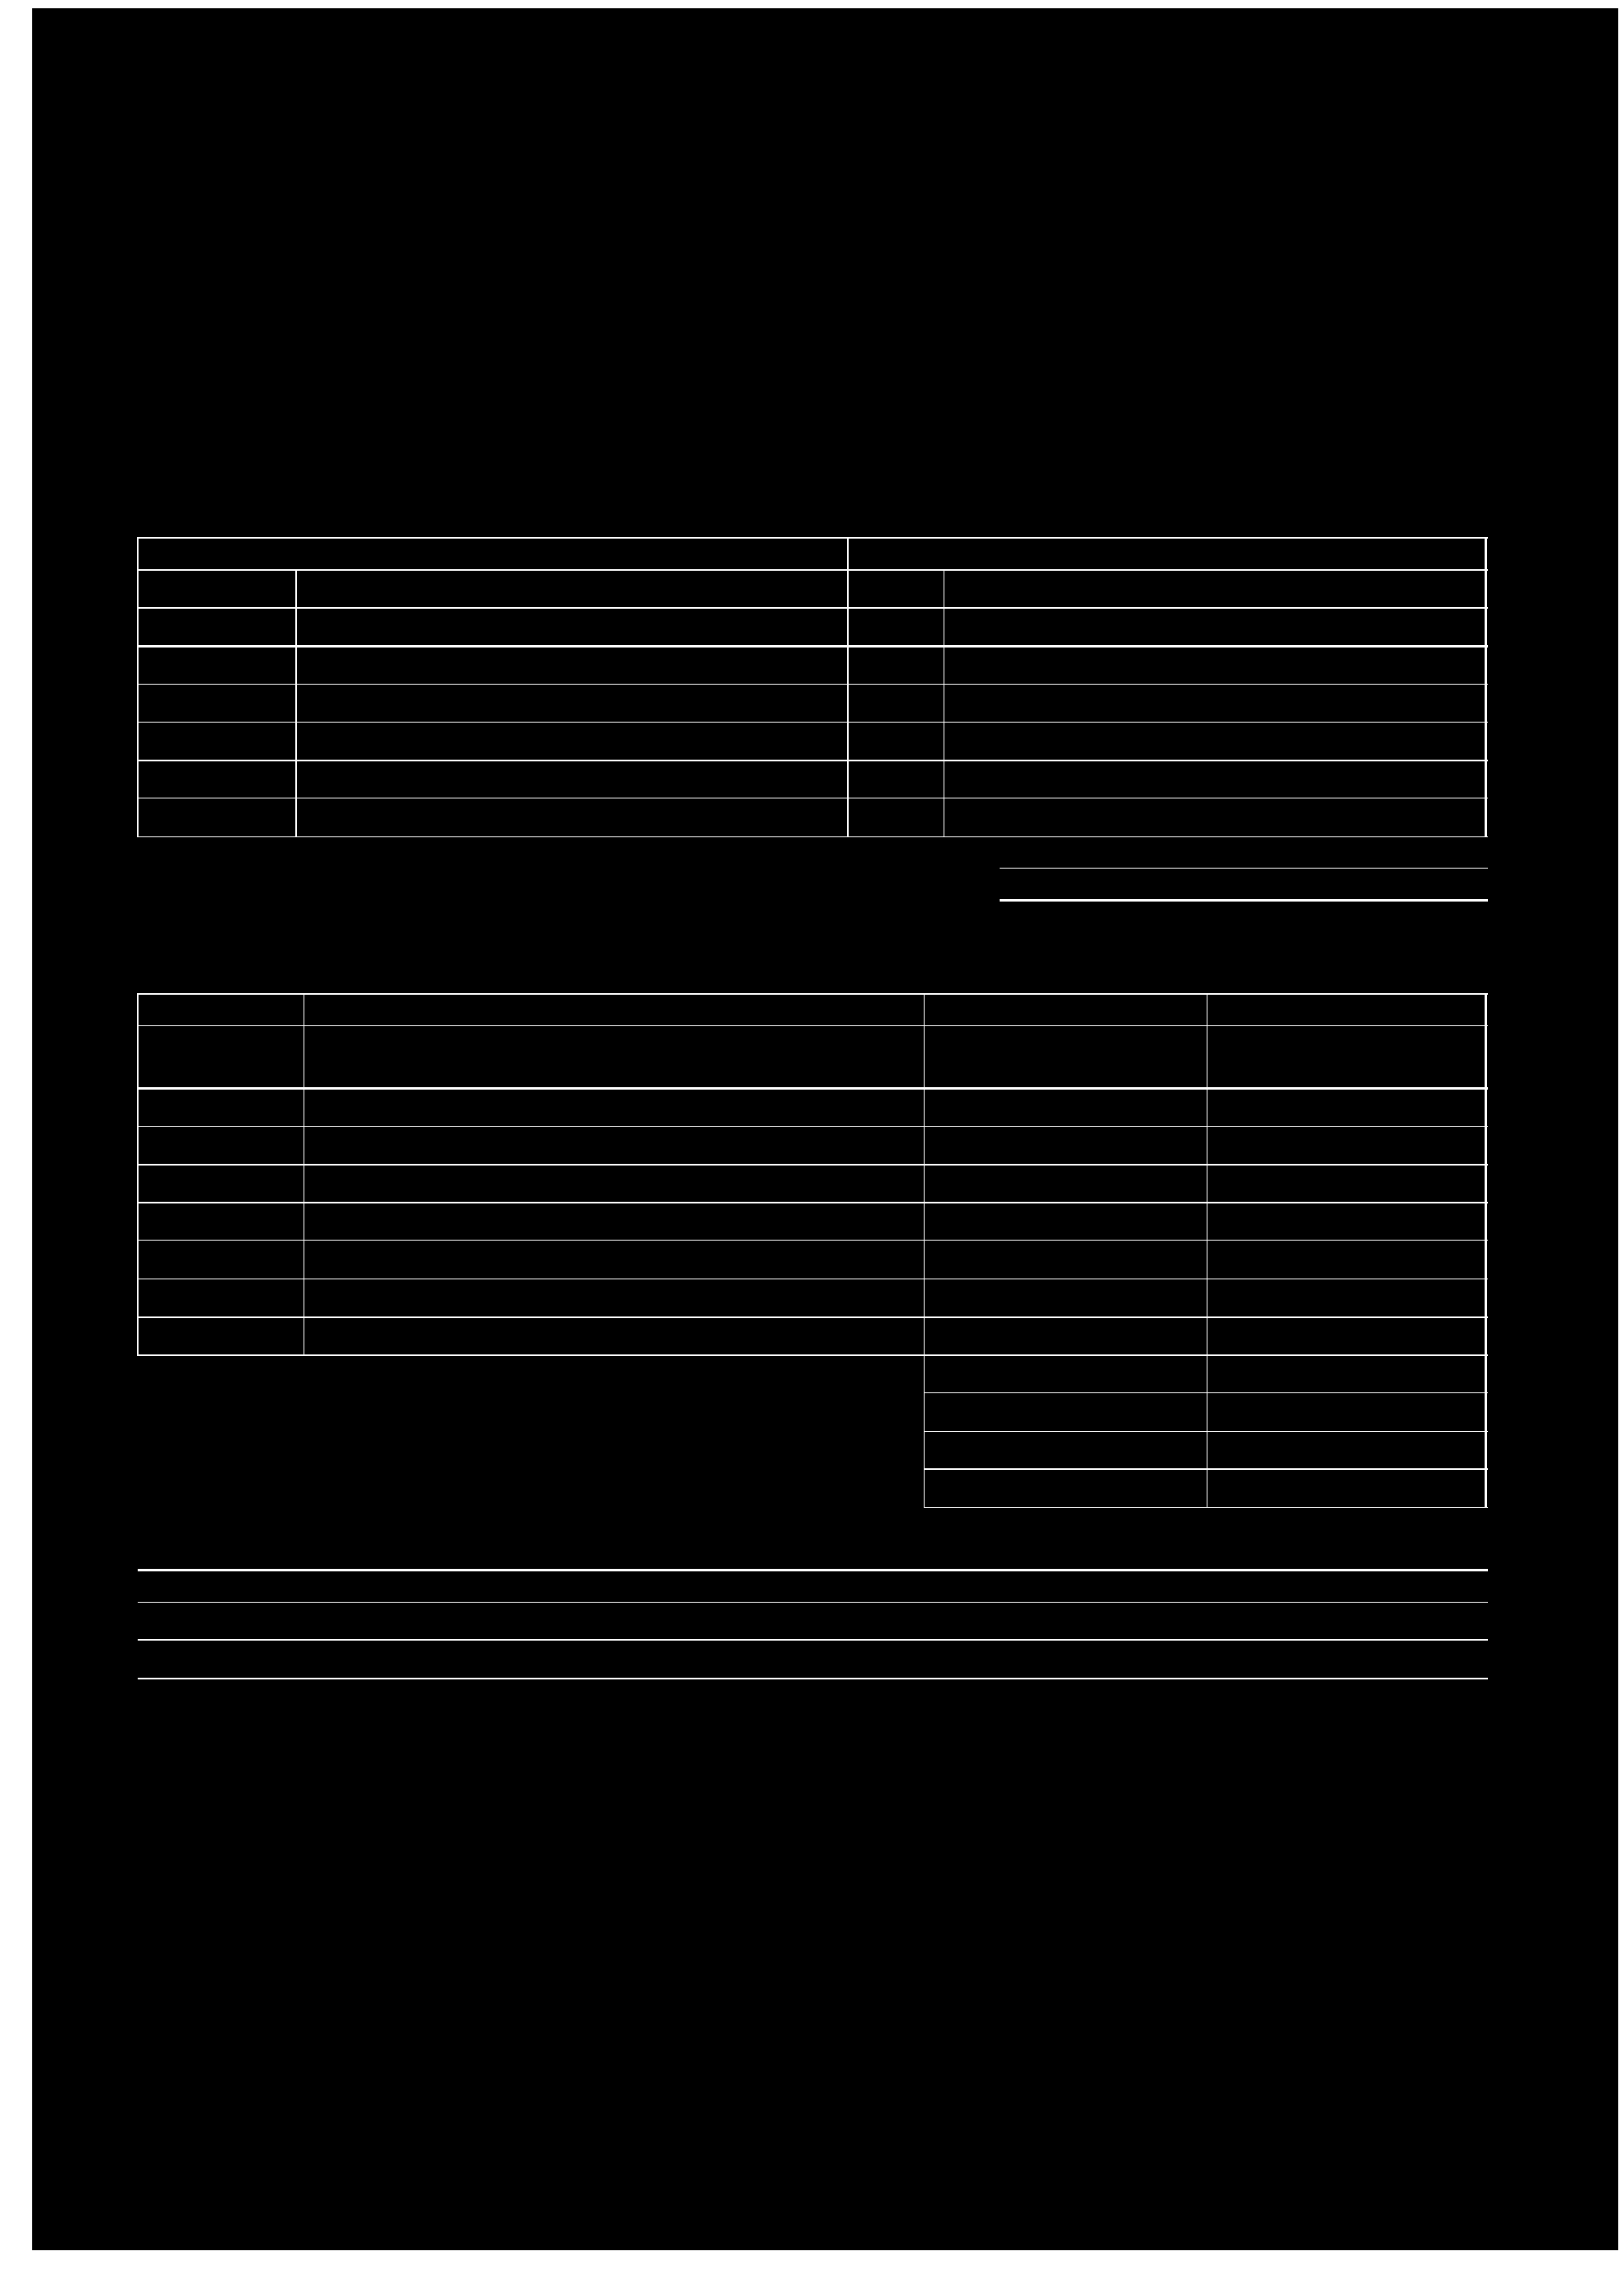

In [67]:
import matplotlib.pyplot as plt
# set size
plt.figure(figsize=(50,50))
plt.axis("off")

plt.imshow( cv2.cvtColor(horizontal_mask+ vertical_mask, cv2.COLOR_BGR2RGB) )
plt.show()

Nous combinons les lignes horizontales et verticales. L'objectif est d'obtenir une structure tabulaire claire pour détecter chaque cellule, et de trouver les intersections des lignes présentes sur l'image.

In [68]:
def find_contours(vertical, horizontal):
    """Finds table boundaries using OpenCV's findContours.
    Parameters
    ----------
    vertical : object
        numpy.ndarray representing pixels where vertical lines lie.
    horizontal : object
        numpy.ndarray representing pixels where horizontal lines lie.
    Returns
    -------
    cont : list
        List of tuples representing table boundaries. Each tuple is of
        the form (x, y, w, h) where (x, y) -> left-top, w -> width and
        h -> height in image coordinate space.
    """
    mask = vertical + horizontal

    try:
        __, contours, __ = cv2.findContours(
            mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )
    except ValueError:
        # for opencv backward compatibility
        contours, __ = cv2.findContours(
            mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )
    # sort in reverse based on contour area and use first 10 contours
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

    cont = []
    for c in contours:
        c_poly = cv2.approxPolyDP(c, 3, True)
        x, y, w, h = cv2.boundingRect(c_poly)
        cont.append((x, y, w, h))
    return cont, mask


def find_joints(contours, vertical, horizontal):
    """Finds joints/intersections present inside each table boundary.
    Parameters
    ----------
    contours : list
        List of tuples representing table boundaries. Each tuple is of
        the form (x, y, w, h) where (x, y) -> left-top, w -> width and
        h -> height in image coordinate space.
    vertical : object
        numpy.ndarray representing pixels where vertical lines lie.
    horizontal : object
        numpy.ndarray representing pixels where horizontal lines lie.
    Returns
    -------
    tables : dict
        Dict with table boundaries as keys and list of intersections
        in that boundary as their value.
        Keys are of the form (x1, y1, x2, y2) where (x1, y1) -> lb
        and (x2, y2) -> rt in image coordinate space.
    """
    joints = np.multiply(vertical, horizontal)
    tables = {}
    for c in contours:
        x, y, w, h = c
        roi = joints[y : y + h, x : x + w]
        try:
            __, jc, __ = cv2.findContours(
                roi.astype(np.uint8), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE
            )
        except ValueError:
            # for opencv backward compatibility
            jc, __ = cv2.findContours(
                roi.astype(np.uint8), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE
            )
        if len(jc) <= 4:  # remove contours with less than 4 joints
            continue
        joint_coords = []
        for j in jc:
            jx, jy, jw, jh = cv2.boundingRect(j)
            c1, c2 = x + (2 * jx + jw) // 2, y + (2 * jy + jh) // 2
            joint_coords.append((c1, c2))
        tables[(x, y+h , x + w, y)] = joint_coords

    return tables

In [69]:
contours, mask = find_contours(vertical_mask, horizontal_mask)

In [70]:
table_bbox = find_joints(contours, vertical_mask, horizontal_mask)

In [71]:
import cv2
image_joint = image.copy()
color = (0, 0, 255)
thickness = 2

for tab  in table_bbox.keys():
    x1, y2, x2, y1 = tab
    cv2.rectangle(image_joint, (int(x1), int(y1)), (int(x2), int(y2)), color, thickness)
    for cord in table_bbox[tab]:
        image_joint = cv2.circle(image_joint, (cord[0],cord[1]), radius=7, color=(0, 0, 255), thickness=-1)

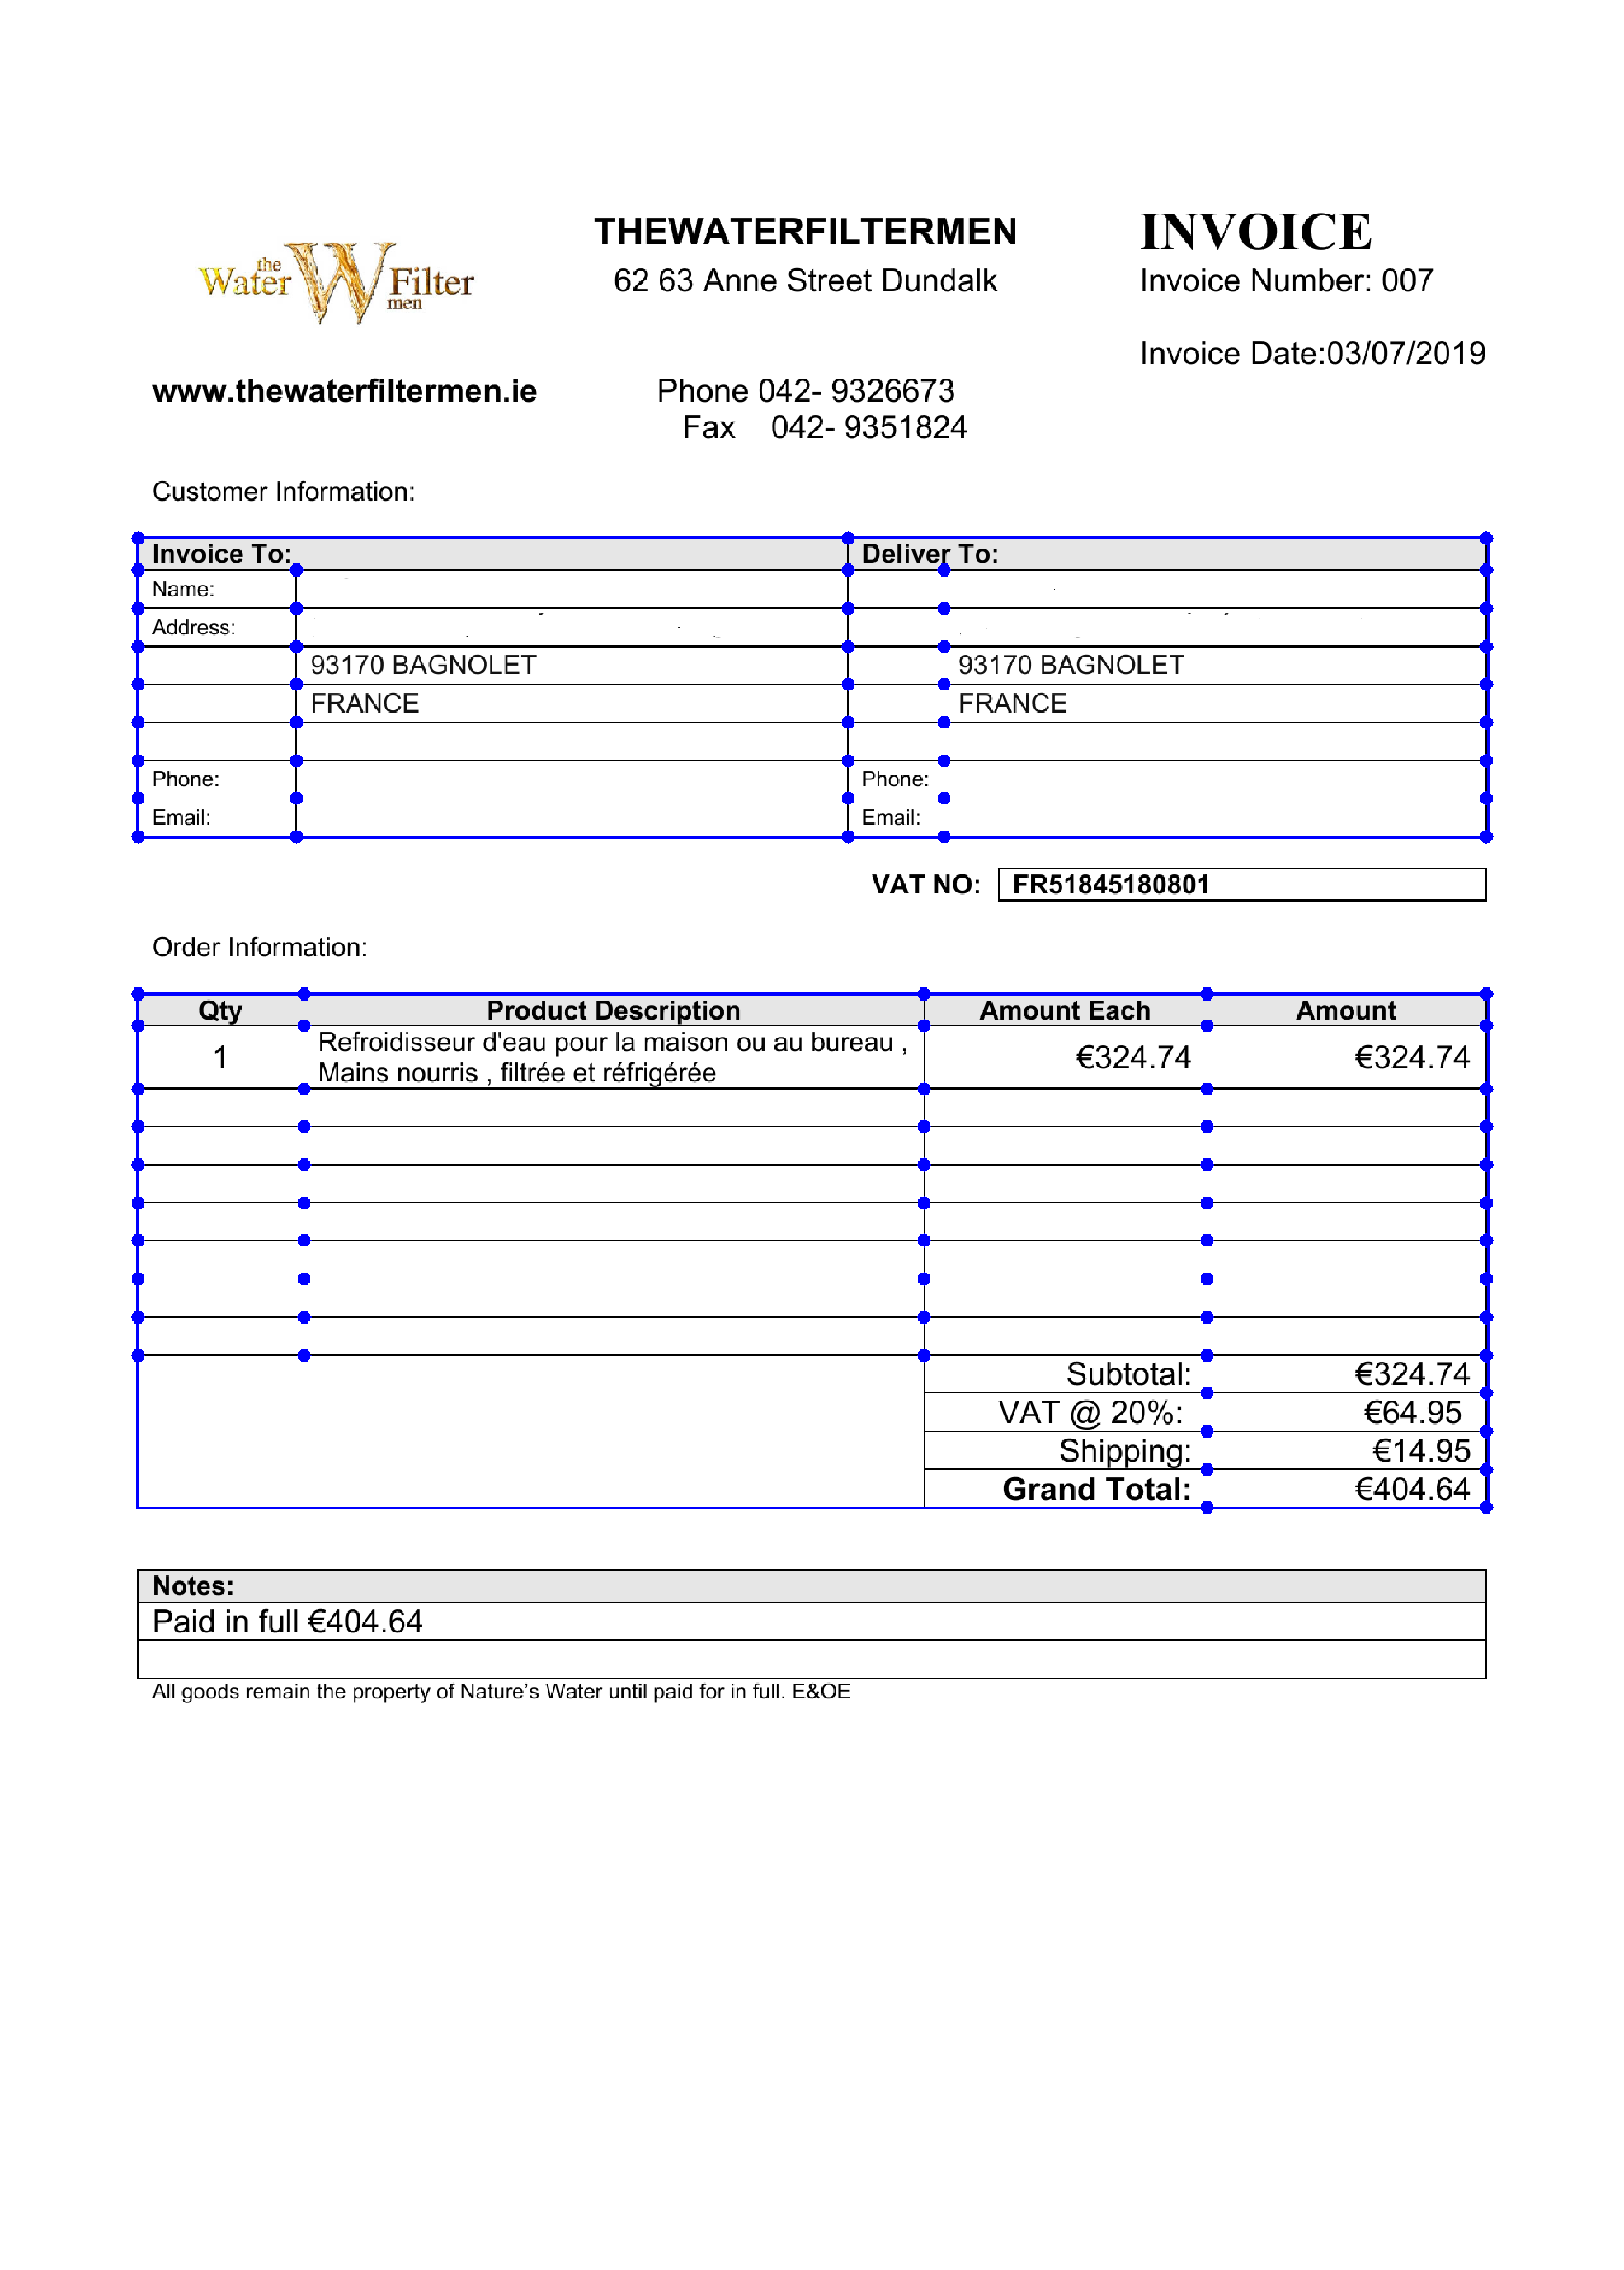

In [43]:
import matplotlib.pyplot as plt
# set size
plt.figure(figsize=(50,50))
plt.axis("off")

plt.imshow(image_joint)
plt.show()

In [72]:
import copy
image_height = image.shape[0]
table_bbox_untranslate = copy.deepcopy(table_bbox)

# Récupérer la position des cellules
Les étapes suivantes sont nécessaires pour définir le bon emplacement des cellules, c'est-à-dire la colonne et la ligne appropriées, de chaque cellule. En basant sur l'intersection des lignes horizontale et verticale pour recuprer les cordonner de chaque cellule et sa postion dans le table.

In [74]:
import numpy as np


def translate(x1, x2):
    """Translate x2 by x1.
    
    Parameters
    --------------
    x1 : float
    x2 : float
    
    Returns
    -------
    x2 : float
    
    """
    
    x2 += x1
    return x2


def translates(tables, v_segments, h_segments, image_height):
    tables_new = {}
    for k in tables.keys():
        x1, y1, x2, y2 = k
        y1 = abs(translate(-image_height, y1))
        y2 = abs(translate(-image_height, y2))
        j_x, j_y = zip(*tables[k])
        j_y = [abs(translate(-image_height, j))  for j in j_y]
        joints = list(zip(j_x, j_y))
        tables_new[(x1, y1, x2, y2)] = joints
    v_segments_new = []
    
    for v in v_segments:
        x1 , x2 = v[0], v[2]
        y1, y2 = abs(translate(-image_height, v[1])), abs(translate(-image_height, v[3]))
        
        v_segments_new.append((x1, y1, x2, y2))
    h_segments_new = []
    for h in h_segments:
        x1 , x2 = v[0], v[2]
        y1, y2 = abs(translate(-image_height, h[1])), abs(translate(-image_height, h[3]))
        
        h_segments_new.append((x1, y1, x2, y2))
    return tables_new, v_segments_new, h_segments_new


        
def segments_in_bbox(bbox, v_segments, h_segments):
    """Returns all line segments present inside a bounding box.
    Parameters
    ----------
    bbox : tuple
        Tuple (x1, y1, x2, y2) representing a bounding box where
        (x1, y1) -> lb and (x2, y2) -> rt in coordinate
        space.
    v_segments : list
        List of vertical line segments.
    h_segments : list
        List of vertical horizontal segments.
    Returns
    -------
    v_s : list
        List of vertical line segments that lie inside table.
    h_s : list
        List of horizontal line segments that lie inside table.
    """
    lb = (bbox[0], bbox[1])
    rt = (bbox[2], bbox[3])
    v_s = [
        v
        for v in v_segments
        if v[1] > lb[1] - 2 and v[3] < rt[1] + 2 and lb[0] - 2 <= v[0] <= rt[0] + 2
    ]
    h_s = [
        h
        for h in h_segments
        if h[0] > lb[0] - 2 and h[2] < rt[0] + 2 and lb[1] - 2 <= h[1] <= rt[1] + 2
    ]
    return v_s, h_s


def merge_close_lines(ar, line_tol=2):
    """Merges lines which are within a tolerance by calculating a
    moving mean, based on their x or y axis projections.
    Parameters
    ----------
    ar : list
    line_tol : int, optional (default: 2)
    Returns
    -------
    ret : list
    """
    ret = []
    for a in ar:
        if not ret:
            ret.append(a)
        else:
            temp = ret[-1]
            if np.isclose(temp, a, atol=line_tol):
                temp = (temp + a) / 2.0
                ret[-1] = temp
            else:
                ret.append(a)
    return ret


line_tol = 2

def _generate_columns_and_rows(table_idx, tk):
    # select elements which lie within table_bbox
    t_bbox = {}
    v_s, h_s = segments_in_bbox(
        tk, vertical_segments, horizontal_segments
    )
    
    cols, rows = zip(*table_bbox[tk])
    cols, rows = list(cols), list(rows)
    
    
    cols.extend([tk[0], tk[2]])
    rows.extend([tk[1], tk[3]])
    # sort horizontal and vertical segments
        
    cols = merge_close_lines(sorted(cols), line_tol=line_tol)
    rows = merge_close_lines(sorted(rows, reverse=True), line_tol=line_tol)
    
    # make grid using x and y coord of shortlisted rows and cols
    cols = [(cols[i], cols[i + 1]) for i in range(0, len(cols) - 1)]
    rows = [(rows[i], rows[i + 1]) for i in range(0, len(rows) - 1)]

    return cols, rows, v_s, h_s

In [75]:
table_bbox, vertical_segments, horizontal_segments = translates(table_bbox, vertical_segments, horizontal_segments, image_height)

Si on prend par exemple le premier tableau, on trouve 4 colonnes et 13 lignes

In [78]:
table_idx = 0
tk = list(sorted(table_bbox.keys(), key=lambda x: x[1], reverse=True))[table_idx]
cols, rows, v_s, h_s = _generate_columns_and_rows(table_idx, tk)

In [79]:
print(len(cols))
print(len(rows))

4
8


In [50]:
Une fois que nous avons défini les postion des colonnes et des lignes du tableau, nous pouvons facilement construire la structure
 de notre table.

SyntaxError: invalid syntax (<ipython-input-50-bf84b8adcaf5>, line 1)

In [80]:

class Cell(object):
    """Defines a cell in a table with coordinates relative to a
    left-bottom origin. (image coordinate space)
    Parameters
    ----------
    x1 : float
        x-coordinate of left-bottom point.
    y1 : float
        y-coordinate of left-bottom point.
    x2 : float
        x-coordinate of right-top point.
    y2 : float
        y-coordinate of right-top point.
    Attributes
    ----------
    lb : tuple
        Tuple representing left-bottom coordinates.
    lt : tuple
        Tuple representing left-top coordinates.
    rb : tuple
        Tuple representing right-bottom coordinates.
    rt : tuple
        Tuple representing right-top coordinates.
    left : bool
        Whether or not cell is bounded on the left.
    right : bool
        Whether or not cell is bounded on the right.
    top : bool
        Whether or not cell is bounded on the top.
    bottom : bool
        Whether or not cell is bounded on the bottom.
    hspan : bool
        Whether or not cell spans horizontally.
    vspan : bool
        Whether or not cell spans vertically.
    text : string
        Text assigned to cell.
    """

    def __init__(self, x1, y1, x2, y2):
        self.x1 = x1
        self.y1 = y1
        self.x2 = x2
        self.y2 = y2
        self.lb = (x1, y1)
        self.lt = (x1, y2)
        self.rb = (x2, y1)
        self.rt = (x2, y2)
        self.left = False
        self.right = False
        self.top = False
        self.bottom = False
        self._text = ""

    def __repr__(self):
        return "<Cell x1={} y1={} x2={} y2={}>".format(
            round(self.x1, 2), round(self.y1, 2), round(self.x2, 2), round(self.y2, 2)
        )

    @property
    def text(self):
        return self._text

    @text.setter
    def text(self, t):
        self._text = "".join([self._text, t])
        

class Table(object):
    """Defines a table with coordinates relative to a left-bottom
    origin. (image coordinate space)
    Parameters
    ----------
    cols : list
        List of tuples representing column x-coordinates in increasing
        order.
    rows : list
        List of tuples representing row y-coordinates in decreasing
        order.
    Attributes
    ----------
    df : :class:`pandas.DataFrame`
    shape : tuple
        Shape of the table.
    accuracy : float
        Accuracy with which text was assigned to the cell.
    whitespace : float
        Percentage of whitespace in the table.
    order : int
        Table number in image .
    """

    def __init__(self, cols, rows):
        self.cols = cols
        self.rows = rows
        self.cells = [[Cell(c[0], r[1], c[1], r[0]) for c in cols] for r in rows]
        self.df = None
        self.shape = (0, 0)
        self.accuracy = 0
        self.whitespace = 0

    def __repr__(self):
        return "<{} shape={}>".format(self.__class__.__name__, self.shape)
    
    @property
    def data(self):
        """Returns two-dimensional list of strings in table.
        """
        d = []
        for row in self.cells:
            d.append([cell.text.strip() for cell in row])
        return d


    def set_all_edges(self):
        """Sets all table edges to True.
        """
        for row in self.cells:
            for cell in row:
                cell.left = cell.right = cell.top = cell.bottom = True
        return self

    def set_edges(self, vertical, horizontal, joint_tol=2):
        """Sets a cell's edges to True depending on whether the cell's
        coordinates overlap with the line's coordinates within a
        tolerance.
        Parameters
        ----------
        vertical : list
            List of detected vertical lines.
        horizontal : list
            List of detected horizontal lines.
        """
        for v in vertical:
            # find closest x coord
            # iterate over y coords and find closest start and end points
            i = [
                i
                for i, t in enumerate(self.cols)
                if np.isclose(v[0], t[0], atol=joint_tol)
            ]
            j = [
                j
                for j, t in enumerate(self.rows)
                if np.isclose(v[3], t[0], atol=joint_tol)
            ]
            k = [
                k
                for k, t in enumerate(self.rows)
                if np.isclose(v[1], t[0], atol=joint_tol)
            ]
            if not j:
                continue
            J = j[0]
            if i == [0]:  # only left edge
                L = i[0]
                if k:
                    K = k[0]
                    while J < K:
                        self.cells[J][L].left = True
                        J += 1
                else:
                    K = len(self.rows)
                    while J < K:
                        self.cells[J][L].left = True
                        J += 1
            elif i == []:  # only right edge
                L = len(self.cols) - 1
                if k:
                    K = k[0]
                    while J < K:
                        self.cells[J][L].right = True
                        J += 1
                else:
                    K = len(self.rows)
                    while J < K:
                        self.cells[J][L].right = True
                        J += 1
            else:  # both left and right edges
                L = i[0]
                if k:
                    K = k[0]
                    while J < K:
                        self.cells[J][L].left = True
                        self.cells[J][L - 1].right = True
                        J += 1
                else:
                    K = len(self.rows)
                    while J < K:
                        self.cells[J][L].left = True
                        self.cells[J][L - 1].right = True
                        J += 1

        for h in horizontal:
            # find closest y coord
            # iterate over x coords and find closest start and end points
            i = [
                i
                for i, t in enumerate(self.rows)
                if np.isclose(h[1], t[0], atol=joint_tol)
            ]
            j = [
                j
                for j, t in enumerate(self.cols)
                if np.isclose(h[0], t[0], atol=joint_tol)
            ]
            k = [
                k
                for k, t in enumerate(self.cols)
                if np.isclose(h[2], t[0], atol=joint_tol)
            ]
            if not j:
                continue
            J = j[0]
            if i == [0]:  # only top edge
                L = i[0]
                if k:
                    K = k[0]
                    while J < K:
                        self.cells[L][J].top = True
                        J += 1
                else:
                    K = len(self.cols)
                    while J < K:
                        self.cells[L][J].top = True
                        J += 1
            elif i == []:  # only bottom edge
                L = len(self.rows) - 1
                if k:
                    K = k[0]
                    while J < K:
                        self.cells[L][J].bottom = True
                        J += 1
                else:
                    K = len(self.cols)
                    while J < K:
                        self.cells[L][J].bottom = True
                        J += 1
            else:  # both top and bottom edges
                L = i[0]
                if k:
                    K = k[0]
                    while J < K:
                        self.cells[L][J].top = True
                        self.cells[L - 1][J].bottom = True
                        J += 1
                else:
                    K = len(self.cols)
                    while J < K:
                        self.cells[L][J].top = True
                        self.cells[L - 1][J].bottom = True
                        J += 1

        return self

    def set_border(self):
        """Sets table border edges to True.
        """
        for r in range(len(self.rows)):
            self.cells[r][0].left = True
            self.cells[r][len(self.cols) - 1].right = True
        for c in range(len(self.cols)):
            self.cells[0][c].top = True
            self.cells[len(self.rows) - 1][c].bottom = True
        return self

In [81]:
joint_tol = 2
#
table = Table(cols, rows)
# set table edges to True using ver+hor lines
table = table.set_edges(v_s, h_s, joint_tol=joint_tol)
# set table border edges to True
table = table.set_border()

In [82]:
table.data

[['', '', '', ''],
 ['', '', '', ''],
 ['', '', '', ''],
 ['', '', '', ''],
 ['', '', '', ''],
 ['', '', '', ''],
 ['', '', '', ''],
 ['', '', '', '']]

# Supprimer toutes les lignes dans l'image (conserver que du textes)
pour améliorer la sortie de tesseract, il est suggéré de supprimer toutes les lignes verticales et horizontales dans les tableaux

In [83]:
def remove_lines(image):
    lines = vertical_mask + horizontal_mask
    kernel = np.ones((5, 5), np.uint8)  # note this is a horizontal kernel
    lines = cv2.dilate(lines, kernel, iterations=1)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    image = cv2.bitwise_or(image, lines, mask=None)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

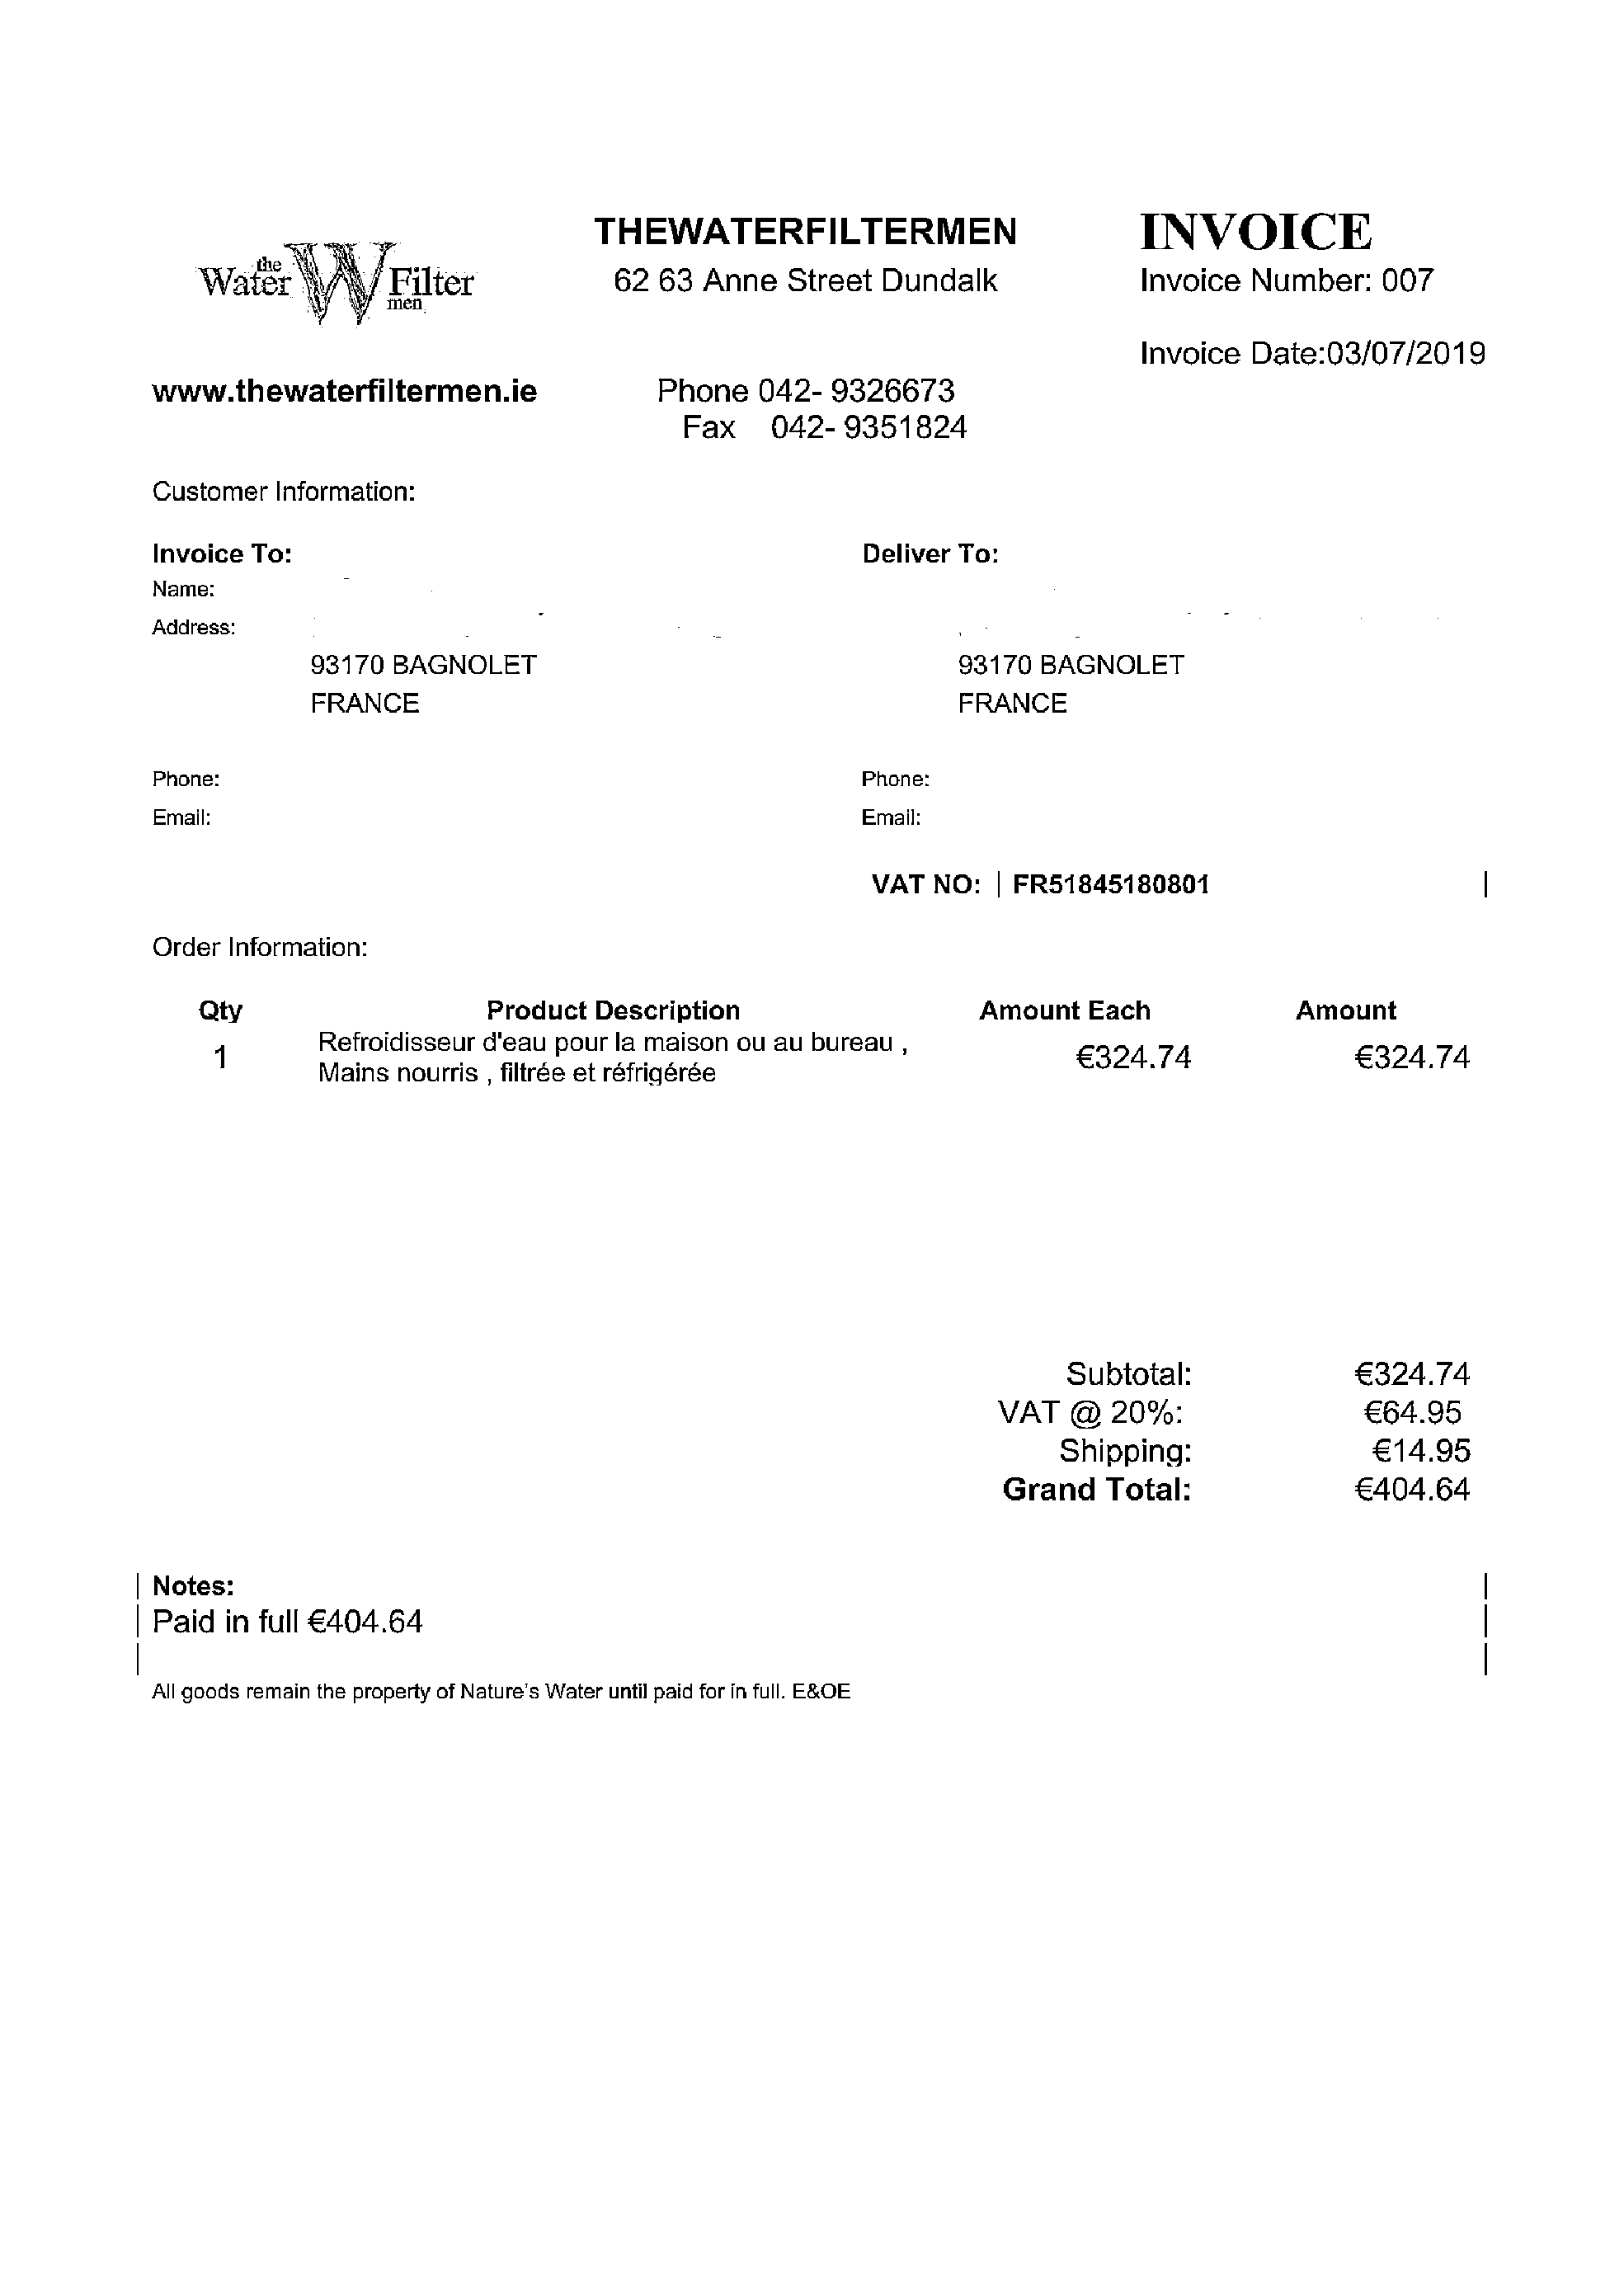

In [84]:
image_remove_ligne = remove_lines(image)
import matplotlib.pyplot as plt
# set size
plt.figure(figsize=(50,50))
plt.axis("off")

plt.imshow(image_remove_ligne)
plt.show()

# Extraction de texte
Comme notre image ne contient plus de lignes, nous pouvons appliquer tesseract pour extraire le texte  

In [85]:
class Text(object):
    def __init__(self, x1, y1, x2, y2, text):
        self.x0 = x1
        self.y0 = y1
        self.x1 = x2
        self.y1 = y2
        self._objs = text
    def __repr__(self):
        return "<Text x1={} y1={} x2={} y2={} text={}>".format(
            round(self.x0, 2), round(self.y0, 2), round(self.x1, 2), round(self.y1, 2), self._objs
        )
    def get_text(self):
        return self._objs
    
        
def get_text_box(tess_result,x1,y1):
    t_box=[]
    for idx, text in enumerate(tess_result['text']):
        if len(text)>0 and tess_result['conf'][idx]>0:
            x, y, w, h = (tess_result['left'][idx], tess_result['top'][idx], tess_result['width'][idx], tess_result['height'][idx]) 
            x = x+x1
            y = y+y1
            t_box.append(Text(x, abs(translate(-image_height, y)), x+w, abs(translate(-image_height, y+h)), text))
    return t_box

In [86]:
import pytesseract
from pytesseract import Output
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract'

x1, y2 , x2, y1 = tk
image_table = image_remove_ligne[image_height-y1: image_height-y2,x1:x2]
results = pytesseract.image_to_data(image_table, output_type=Output.DICT)
t_box = get_text_box(results,x1, image_height-y1)

In [87]:
t_box

[<Text x1=127 y1=1779 x2=220 y2=1759 text=Invoice>,
 <Text x1=229 y1=1779 x2=269 y2=1759 text=To:>,
 <Text x1=126 y1=1740 x2=189 y2=1724 text=Name:>,
 <Text x1=125 y1=1700 x2=211 y2=1684 text=Address:>,
 <Text x1=126 y1=1542 x2=194 y2=1526 text=Phone:>,
 <Text x1=126 y1=1502 x2=185 y2=1486 text=Email:>,
 <Text x1=291 y1=1663 x2=366 y2=1642 text=93170>,
 <Text x1=377 y1=1663 x2=526 y2=1643 text=BAGNOLET>,
 <Text x1=292 y1=1623 x2=403 y2=1603 text=FRANCE>,
 <Text x1=867 y1=1779 x2=958 y2=1759 text=Deliver>,
 <Text x1=965 y1=1779 x2=1006 y2=1759 text=To:>,
 <Text x1=866 y1=1542 x2=934 y2=1526 text=Phone:>,
 <Text x1=866 y1=1502 x2=925 y2=1486 text=Email:>,
 <Text x1=966 y1=1663 x2=1041 y2=1642 text=93170>,
 <Text x1=1052 y1=1663 x2=1201 y2=1643 text=BAGNOLET>,
 <Text x1=967 y1=1623 x2=1078 y2=1603 text=FRANCE>]

Tout ce que nous avons à faire est de remplir les cases avec du texte. pour cella on vas utiliser les cellules de la table pour recuperer le text correspondants à partir des resulats de tesseract. 

In [88]:
def text_strip(text, strip=""):
    """Strips any characters in `strip` that are present in `text`.
    Parameters
    ----------
    text : str
        Text to process and strip.
    strip : str, optional (default: '')
        Characters that should be stripped from `text`.
    Returns
    -------
    stripped : str
    """
    if not strip:
        return text

    stripped = re.sub(
        r"[{}]".format("".join(map(re.escape, strip))), "", text, re.UNICODE
    )
    return stripped


def compute_accuracy(error_weights):
    """Calculates a score based on weights assigned to various
    parameters and their error percentages.
    Parameters
    ----------
    error_weights : list
        Two-dimensional list of the form [[p1, e1], [p2, e2], ...]
        where pn is the weight assigned to list of errors en.
        Sum of pn should be equal to 100.
    Returns
    -------
    score : float
    """
    SCORE_VAL = 100
    try:
        score = 0
        if sum([ew[0] for ew in error_weights]) != SCORE_VAL:
            raise ValueError("Sum of weights should be equal to 100.")
        for ew in error_weights:
            weight = ew[0] / len(ew[1])
            for error_percentage in ew[1]:
                score += weight * (1 - error_percentage)
    except ZeroDivisionError:
        score = 0
    return score


def get_table_index(
    table, t , strip_text=""
):
    """Gets indices of the table cell where given text object lies by
    comparing their y and x-coordinates.
    Parameters
    ----------
    table : camelot.core.Table
    t : object output tessetact.
    strip_text : str, optional (default: '')
        Characters that should be stripped from a string before
        assigning it to a cell.
    Returns
    -------
    indices : list
        List of tuples of the form (r_idx, c_idx, text) where r_idx
        and c_idx are row and column indices.
    error : float
        Assignment error, percentage of text area that lies outside
        a cell.
        +-------+
        |       |
        |   [Text bounding box]
        |       |
        +-------+
    """
    r_idx, c_idx = [-1] * 2
    for r in range(len(table.rows)):
        if (t.y0 + t.y1) / 2.0 < table.rows[r][0] and (t.y0 + t.y1) / 2.0 > table.rows[
            r
        ][1]:
            lt_col_overlap = []
            for c in table.cols:
                if c[0] <= t.x1 and c[1] >= t.x0:
                    left = t.x0 if c[0] <= t.x0 else c[0]
                    right = t.x1 if c[1] >= t.x1 else c[1]
                    lt_col_overlap.append(abs(left - right) / abs(c[0] - c[1]))
                else:
                    lt_col_overlap.append(-1)
            if len(list(filter(lambda x: x != -1, lt_col_overlap))) == 0:
                text = t.get_text().strip("\n")
                text_range = (t.x0, t.x1)
                col_range = (table.cols[0][0], table.cols[-1][1])
                warnings.warn(
                    "{} {} does not lie in column range {}".format(
                        text, text_range, col_range
                    )
                )
            r_idx = r
            c_idx = lt_col_overlap.index(max(lt_col_overlap))
            break

    # error calculation
    y0_offset, y1_offset, x0_offset, x1_offset = [0] * 4
    if t.y0 > table.rows[r_idx][0]:
        y0_offset = abs(t.y0 - table.rows[r_idx][0])
    if t.y1 < table.rows[r_idx][1]:
        y1_offset = abs(t.y1 - table.rows[r_idx][1])
    if t.x0 < table.cols[c_idx][0]:
        x0_offset = abs(t.x0 - table.cols[c_idx][0])
    if t.x1 > table.cols[c_idx][1]:
        x1_offset = abs(t.x1 - table.cols[c_idx][1])
    X = 1.0 if abs(t.x0 - t.x1) == 0.0 else abs(t.x0 - t.x1)
    Y = 1.0 if abs(t.y0 - t.y1) == 0.0 else abs(t.y0 - t.y1)
    charea = X * Y
    error = ((X * (y0_offset + y1_offset)) + (Y * (x0_offset + x1_offset))) / charea
    return [(r_idx, c_idx, text_strip(t.get_text(), strip_text))], error
        

In [89]:
import pandas as pd
for t in t_box:
        indices, error = get_table_index(
            table,
            t,
        )
        
        if indices[:2] != (-1, -1):
            for r_idx, c_idx, text in indices:
                table.cells[r_idx][c_idx].text = ' '+ text
data = table.data
table.df = pd.DataFrame(data)
table.shape = table.df.shape

In [90]:
table.df

,0,1,2,3
0,Invoice To:,,Deliver,To:
1,Name:,,,
2,Address:,,,
3,,93170 BAGNOLET,,93170 BAGNOLET
4,,FRANCE,,FRANCE
5,,,,
6,Phone:,,Phone:,
7,Email:,,Email:,


C'est ça! Votre tableau doit maintenant être stocké dans une base de données et dans un fichier Excel et peut être utilisé pour le traitement du langage naturel, pour une analyse plus approfondie via des statistiques ou simplement pour l'éditer. Cela fonctionne pour les tables avec une structure claire et simple. Dans le cas où votre tableau a une structure extraordinaire, dans le sens où de nombreuses cellules sont combinées, que la taille des cellules varie fortement ou que de nombreuses couleurs sont utilisées, l'algorithme devra peut-être être adopté. De plus, l'OCR (pytesseract) est presque parfait pour reconnaître les polices informatiques. Cependant, si vous avez des tableaux contenant des entrées manuscrites, les résultats peuvent varier.

## Reference
* https://github.com/atlanhq/camelot
* https://nanonets.com/blog/table-extraction-deep-learning/